# Intro to Salvus

Lars Gebraad

_Copyright Mondaic AG, for the University of Bristol, January 2025._

Adapted from [this public tutorial](https://mondaic.com/docs/examples/tutorials/getting_started/tutorial_part1).

## Part 1 - First simulation

An accurate solution to the wave equation is a requirement for a wide variety of seismological research. In this tutorial, we will validate the accuracy of Salvus by comparing numerically calculated seismograms to semi-analytical solutions of Lamb's Problem in 2-D. In addition to giving us confidence in the synthetic data we will use in future tutorials, it also gives us a chance to gently learn some of the key features of the Salvus<i>Project</i> API.

Lamb's problem is concerned with the behavior of the elastic wave equation in the presence of a half-space bounded by a free-surface condition. In our solution we expect both direct arrivals and those reflected from the free-surface, along with a contribution from the 2-D Rayleigh wave. We'll consider a half-space bounded at $y=2000$, and excite waves using a Ricker source with a center frequency of 15 Hz. This setup keeps compute times very low, while also allowing for a fair amount of wavelengths to propagate within our domain. To get started, let's first import all the Python tools we'll need.

In [180]:
SALVUS_FLOW_SITE_NAME = "local"
RANKS = 8
PROJECT_NAME = "project_01"

In [181]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np

# Main Salvus import
import salvus.namespace as sn

from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)

## Initializing a project and its domain

Before we initialize our project, we'll first need to initialize the spatial domain to which our project corresponds. In this case we'll be using a simple 2-D box domain. Don't worry, we'll make things a bit more exciting in future tutorials. The box domain can easily be constructed from a set of two-dimensional extents as shown in the cell below.

In [182]:
d = sn.domain.dim2.BoxDomain(x0=0.0, x1=2e3, y0=0.0, y1=1000.0)

For a given project the domain we specify is immutable; its extents and characteristics are used to infer other information regarding our meshes, simulations, and data. With the simple domain definition given above, we're now ready to initialize our project. To do this we can use the `Project.from_domain()` constructor as shown below. This function takes a path and a domain object such as the one we just constructed. Calling this function several times will load the project state from disk instead. The project state is persistent and not tied to this notebook, so you can easily take a break and continue working on the project anytime.

In [183]:
p = sn.Project.from_domain(path=PROJECT_NAME, domain=d, load_if_exists=True)

Accordion()

Most entities of a project can be visualized in a notebook widget by calling `p.viz.nb.` followed by the name of the entity. Currently the project does not contain a lot of data yet, but at least we can visualize the domain extent.

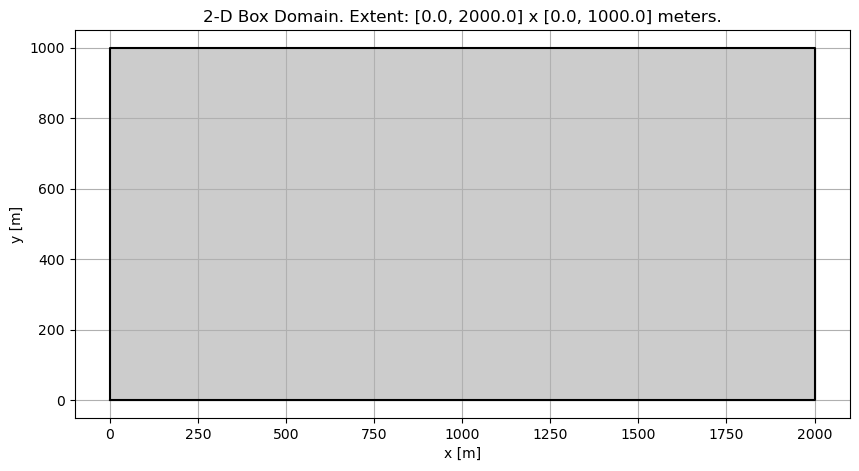

In [184]:
p.viz.nb.domain()

## Specifying sources and receivers

Next, we need to set up a source and a few receivers. To facilitate this we'll use several `simple_config` objects from Salvus<i>Flow</i> above. You can use the `tab` key to browse through the different categories and to see a list of all available options, or check the documentation [here](https://mondaic.com/docs/0.12.0/references/python_api/salvus/flow/simple_config/source).

In the benchmark in part 2, we will be comparing the simulated seismograms to the semi-analytic response of 2-D vector point source with components $[0, -1e10]$ at a position of $[1000, 500]$. Here, forces are specified in Newton-meters, with positions in meters.

In [185]:
sn.simple_config.source.cartesian.VectorPoint2D # elastic
sn.simple_config.source.cartesian.ScalarPoint2D # acoustic

sn.simple_config.source.cartesian.MomentTensorPoint2D # elastic, but attach to the boundary

salvus.flow.simple_config.source.cartesian.MomentTensorPoint2D

In [186]:
src = sn.simple_config.source.cartesian.VectorPoint2D(
    x=1000.0, y=500.0, fx=0.0, fy=-1e10
)

Note that we only specify the spatial characteristics of the source at this time. The temporal parameters, most importantly the frequency content of the source wavelet, is tightly coupled to the discretization of the domain. It is common to run several simulations using different frequency bands, which is why those parameters will be defined later as part of the `SimulationConfiguration`.

As measurement locations, we'll set up a line of 5 equidistantly spaced receivers between $x=1010.0$ m and $x=1410.0$ m, at a `y` position of 800 m. We need to specify a unique station code for each receiver, as well as a list of which fields we'd like the receivers to record (displacement in this case).

In [187]:
# Python list comprehension
recs = [
    sn.simple_config.receiver.cartesian.Point2D(
        y=800.0,
        x=x,
        network_code="XX",
        station_code=f"REC{i + 1}",
        fields=["displacement", "velocity"], # Variable
    )
    for i, x in enumerate(np.linspace(1010.0, 1410.0, 5))
]

With our sources and receivers now defined, we can add the combination of them as an `Event` to our project. Every event requires a unique name.

In [188]:
p.add_to_project(
    sn.Event(event_name="event_0", sources=src, receivers=recs)
) 

Note here the syntax we used. An `Event`, along with several other relevant objects, can be added to a project by calling `add_to_project` or simply using the `+=` operator. Once the object is successfully added to the project it is then \"serialized\", or saved, within the project directory structure. The power and usefulness of this concept will become apparent in a later tutorial. For now all you need to know is that the event is officially a part of our project!

We can verify this by plotting the domain again.

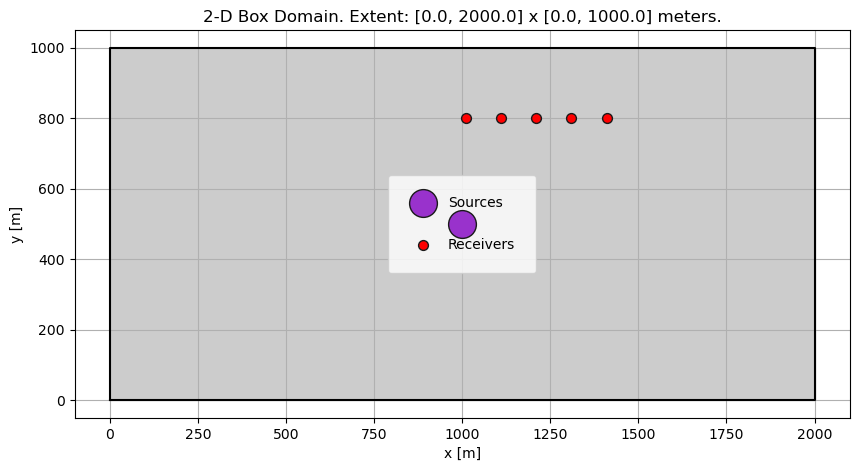

In [189]:
p.viz.nb.domain()

That's enough setup for now. Let's get going with some simulations.

## Running a simulation

What is still missing for our first simulation? We have not yet specified the material properties within our domain, nor the time characteristics of the source. Both influence the wavelengths in the simulation and thus the mesh that discretizes the domain.

#### Defining a model

The analytical solution was computed in an unbounded homogeneous isotropic elastic medium with material parameters specified in SI units as $(\rho = 2200, v_p = 3200, v_s = 1847.5)$. As the analytic solution was computed in a homogeneous medium, we don't need to concern ourselves with (2- or 3-D) heterogeneities of volumetric models for now. So, the next step is to define our homogeneous medium using the Salvus interface for a `background_model`.

In [190]:
mc = sn.ModelConfiguration(
    background_model=sn.model.background.homogeneous.IsotropicElastic(
        rho=2200.0, vp=3200.0, vs=1847.5
    )
)

#### Defining time- and frequency-dependent parameters

Note that up until now we have not specified any information regarding the frequency content of the data we are planning on simulating, and in fact all the parameters we've specified have been frequency-independent. This is deliberate, as it is often the case that information on material parameters are provided independent of frequency. The next step is to add a time-frequency axis to our project, which enters in the form of an `EventConfiguration`. Here, at a bare minimum, we need to specify what type of source wavelet we would like to model, and to provide some basic information about the temporal extent of our upcoming simulations. The reference data were computed with using a Ricker wavelet centered around time $t=0$ and with a center frequency of $14.5$ Hz. The time interval spans a bit more than 0.5 seconds. These parameters are now used to define our `EventConfiguration` object. The start time is optional and only necessary here for comparing with the analytic solution in the next part. Salvus will auto-derive an appropriate start time if not given. Because the Ricker wavelet is centered around zero, we have non-zero contributions before $t=0$ and consequently need to start the simulation at a negative starting time.

In [191]:
sn.WaveformSimulationConfiguration()

{'physics': {'wave_equation': {'attenuation': False,
                               'time_stepping_scheme': 'newmark'}}}

In [192]:
ec = sn.EventConfiguration(
    wavelet=sn.simple_config.stf.Ricker(center_frequency=14.5),
    waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
        start_time_in_seconds=-0.08,
        end_time_in_seconds=0.6,
    ),
)

To get a better sense of what our wavelet looks like in both the time and frequency domain, we can easily plot its characteristics in the cell below.

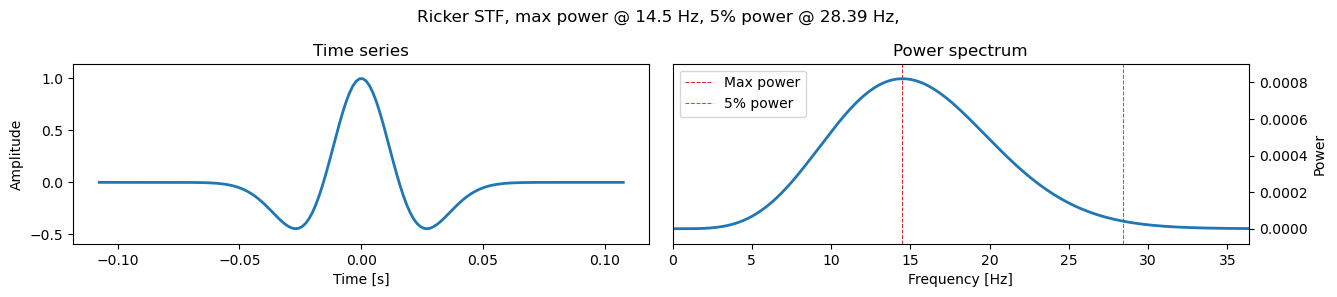

In [193]:
ec.wavelet.plot()

We quickly see that, while the center frequency of the wavelet was specified to be $14.5$ Hz, there is actually a fair bit of energy that exists at frequencies higher than this. Its important to design our simulations so that they properly resolve all the frequencies we are interested in.

#### Defining simulation parameters

The final step in defining a simulation is pulling together all the above into a single reproducible `SimulationConfiguration`. A `SimulationConfiguration` is a unique identifier that brings together the model, the source wavelet parameterization, and a proxy of the resolution of the simulation together.
Depending on the application, sufficient accuracy is typically achieved with 7 to 10 grid points per wavelength, sometimes even less. By default, we use a polynomial degree of 4 in the spectral-element mesh, which gives 5 grid points per element. Here, we need to specify `elements_per_wavelength` and choose `1.0`.

The question then remains: given a broadband source wavelet, which frequency do we want to mesh for? The wavelet plot above gives us a clue: the vast majority of the energy in the current wavelet is contained at frequencies below $30$ Hz. For our first attempt at matching the analytic solution then, we'll require that our mesh be generated using one element per wavelength at a frequency of $30$ Hz. As you are probably becoming familiar with by now, we can add the relevant `SimulationConfiguration` to our project as below.

In [194]:
p.add_to_project(
    sn.SimulationConfiguration(
        name="my_first_simulation",
        max_frequency_in_hertz=30.0,
        elements_per_wavelength=1.0,
        model_configuration=mc,
        event_configuration=ec,
    )
)

#### Visualizing the configuration

So far, regarding our simulation, we have:

* Defined a homogeneous material model
* Defined a Ricker wavelet source
* Set a resolution criterion

In fact, this is all we need to do! Before we actually run the simulation though, it can be helpful to get a visual overview of what is about to happen. Salvus project provides a small convenience function to visualize a `SimulationConfiguration` directly in the notebook, as below. This function takes a list of events as well, for the purpose of overplotting sources and receivers on the resultant domain. Let's have a look.

In [195]:
p.events.list()

p.simulations.list()

['my_first_simulation']

In [198]:
p.viz.nb.simulation_setup(
    simulation_configuration="my_first_simulation", events="event_0"
)

[2025-01-30 11:16:47,381] INFO: Creating mesh. Hang on.


Feel free to experiement with the dropdown menus and buttons. This visualization can really help debug obvious issues. At this point those of you familiar with older versions of Salvus might be wondering: Where did the mesh come from? In Salvus<i>Project</i> the complexity of mesh generation is moved into the background and is handled internally via a reference to the `SimulationConfiguration` object. While the benefits of this approach are small for small domains and homogeneous models, they will become much clearer when we consider 3-D models and domains with topography.

#### Running the solver

With everything ready to go, it's now time to run our first simulation! The `launch_simulations` command below takes a few arguments worth describing:

* `site_name`: This is an identifier which tells Salvus*Flow* whether you're running on your local machine, some remote cluster, or perhaps the old chess computer in your grandfather's basement. As long as Salvus has been set up correctly on the specified site all data transfers to / from the local or remote machine will happen automatically. Additionally, if a job management system is present on the remote site Flow will monitor the job queue.

* `ranks_per_job`: This is the number of MPI ranks the job will run on, and can range from 1 to whatever your license will allow.

* `events`: A list of events for which to run simulations for.
* `simulation_configuration`: The configuration for which to run simulations for.

In [199]:
SALVUS_FLOW_SITE_NAME, RANKS

p.events.list()

['event_0']

In [201]:
p.simulations.launch(
    ranks_per_job=RANKS,
    site_name=SALVUS_FLOW_SITE_NAME,
    events="event_0",
    simulation_configuration="my_first_simulation",
)

[2025-01-30 11:16:52,384] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2501301116389382_ced09a3ae8@local


1

And that's it! The simulations are off and running. Salvus<i>Flow</i> will take care of abstracting the machine architecture, and Salvus<i>Project</i> will take care of saving all the output data into the correct location, copying it from any remote machines as necessary. We can get the current status of the simulations by calling `query_simulations()` as below. The parameter `block` specifies that we wait until all simulations are done.

In [202]:
p.simulations.query(block=True)

VBox()

True

## Visualizing waveforms and working with data

Because the simulations are so small, they should not take more than a few seconds to run regardless of the machine. Once they are done, we can visualize the waveforms trace-by-trace.

In [203]:
p.viz.nb.waveforms("my_first_simulation", receiver_field="displacement")

Alternatively, we can query the waveforms to get access to more plotting options, such as `wiggles` or a `shotgather`.

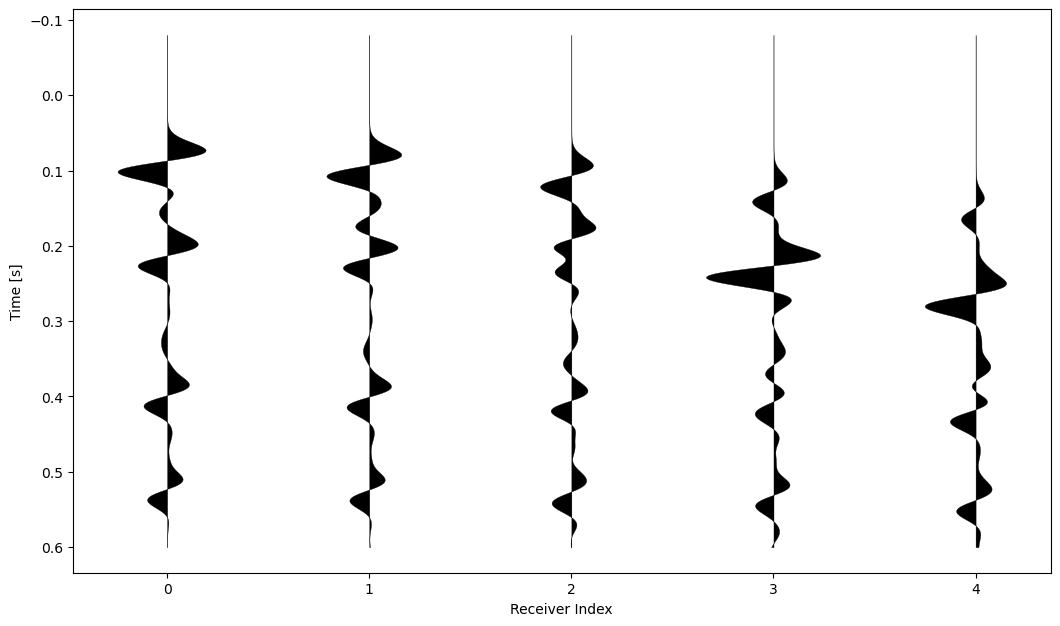

In [204]:
event_data = p.waveforms.get(
    data_name="my_first_simulation", events=["event_0"]
)[0]

event_data.plot(component="Y", receiver_field="displacement")

We can also extract the data as XArray objects:

In [205]:
displacement_data = event_data.get_waveform_data_xarray(
    receiver_field="displacement"
)

displacement_data

<xarray.DataArray 'displacement' (receiver_ids: 5, components: 2, time: 353)> Size: 14kB
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          6.3062273e-04,  6.9069071e-04,  7.1874226e-04],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          3.0253523e-05,  6.2458945e-05,  1.1592330e-04]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.8722445e-03,  1.9455610e-03,  1.9174054e-03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          2.2787642e-04,  3.1537391e-04,  4.1879693e-04]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          2.5625413e-03,  3.8979957e-03,  4.9879253e-03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -4.0976075e-04, -3.9501744e-04, -3.7684722e-04]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -4.3452098e-03, -2.1152359e-03,  2.2821469e-04],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -3.8361127e-04, -8.5348607e-04, -1.2562098e-03]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -1.2543420e-02, -1.2557206e-02, -1.2004769e-02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.7626842e-03,  1.6507027e-03,  1.5490237e-03]]], dtype=float32)
Coordinates:
  * receiver_ids  (receiver_ids) <U8 160B 'XX.REC1.' 'XX.REC2.' ... 'XX.REC5.'
  * components    (components) <U1 8B 'X' 'Y'
  * time          (time) float64 3kB -0.08 -0.07807 -0.07614 ... 0.5981 0.6
Attributes:
    start_time_in_seconds:               -0.08
    sampling_rate_in_hertz:              517.6470588235294
    start_time_in_seconds_utc_datetime:  1969-12-31T23:59:59.920000Z
    end_time_in_seconds_utc_datetime:    1970-01-01T00:00:00.600000Z
    reference_time_utc:                  1970-01-01T00:00:00.000000Z
    reference_time_in_seconds:           0.0
    npts:                                353
    location:                            [[1010.  800.]\n [1110.  800.]\n [12...

## Extra output data and visualizing wavefields

During a simulation, we can also store extra outputs other the the receiver recordings. However, you need to manually tell the simulation interface to store the volumetric data, as that might be **very large**.

In [226]:
p.simulations.launch(
    ranks_per_job=RANKS,
    site_name=SALVUS_FLOW_SITE_NAME,
    events="event_0",
    simulation_configuration="my_first_simulation",
    extra_output_configuration={
        "volume_data": {
            "sampling_interval_in_time_steps": 5,
            "fields": ["displacement"],
        },
        # One could also use the boundaries:
        # "surface_data": {
        #     "sampling_interval_in_time_steps": 20,
        #     "fields": ["acceleration", "velocity"],
        #     "side_sets": ["x0", "x1"],
        # },
    },
    # Note this line!
    delete_conflicting_previous_results=True,
)

p.simulations.query(block=True)

[2025-01-30 11:26:33,250] INFO: delete_conflicting_previous_results is set to True. Deleting results for simulation configuration my_first_simulation and event event_0.
[2025-01-30 11:26:33,256] INFO: Removing contents of `project_01/EVENTS/event_0/WAVEFORM_DATA/INTERNAL/94/32/1dec324e851e`.
[2025-01-30 11:26:33,273] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2501301126278156_838eb2a495@local


VBox()

True

As the data is written on the mesh (so you could look at in ParaView), we need to resample it to something regular for use in Matplotlib.

In [227]:
# First, retrieve the volumetric output file
output_file = pathlib.Path(
    p.simulations.get_simulation_output_directory(
        "my_first_simulation", "event_0"
    ),
    "volume_data_output.h5",
)

output_file

PosixPath('project_01/EVENTS/event_0/WAVEFORM_DATA/INTERNAL/94/32/1dec324e851e/volume_data_output.h5')

In [228]:

# Create a WavefieldOutput object for resampling
volume_output = WavefieldOutput.from_file(
    output_file, "displacement", "volume"
)

In [229]:
wavefields_as_xarray = wavefield_output_to_xarray(
    volume_output,
    [
        np.linspace(0.0, 2000.0, 200),
        np.linspace(0.0, 1000.0, 100),
    ],
).T

Finding enclosing elements (pass 1 of auto):   0%|          | 0/20000 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/4 [00:00<?, ?it/s]

And now, we can easily use XArrays interface to show the wavefields:

In [232]:
wavefields_as_xarray

<xarray.DataArray (y: 100, x: 200, c: 2, t: 72)> Size: 12MB
array([[[[ 0.        ,  0.        ,  0.        , ..., -0.04290228,
          -0.06262376, -0.05719093],
         [ 0.        ,  0.        ,  0.        , ...,  0.05731857,
           0.0406436 ,  0.02026688]],

        [[ 0.        ,  0.        ,  0.        , ..., -0.04250945,
          -0.05879456, -0.05361863],
         [ 0.        ,  0.        ,  0.        , ...,  0.04347484,
           0.01621541, -0.00092514]],

        [[ 0.        ,  0.        ,  0.        , ..., -0.04117085,
          -0.04983991, -0.04437553],
         [ 0.        ,  0.        ,  0.        , ...,  0.02775152,
          -0.00170724, -0.01564741]],

        ...,

        [[ 0.        ,  0.        ,  0.        , ...,  0.04117085,
           0.04983991,  0.04437556],
         [ 0.        ,  0.        ,  0.        , ...,  0.02775154,
...
           0.0498399 ,  0.04437554],
         [ 0.        ,  0.        ,  0.        , ...,  0.02775151,
          -0.00170725, -0.01564741]],

        ...,

        [[ 0.        ,  0.        ,  0.        , ..., -0.04117087,
          -0.04983993, -0.04437554],
         [ 0.        ,  0.        ,  0.        , ...,  0.02775152,
          -0.00170725, -0.01564742]],

        [[ 0.        ,  0.        ,  0.        , ..., -0.04250946,
          -0.05879458, -0.05361864],
         [ 0.        ,  0.        ,  0.        , ...,  0.04347484,
           0.0162154 , -0.00092514]],

        [[ 0.        ,  0.        ,  0.        , ..., -0.04290224,
          -0.06262379, -0.05719095],
         [ 0.        ,  0.        ,  0.        , ...,  0.05731853,
           0.04064361,  0.02026689]]]], dtype=float32)
Coordinates:
  * t        (t) float64 576B -0.08 -0.07034 -0.06068 ... 0.5865 0.5961 0.6058
  * c        (c) int64 16B 0 1
  * x        (x) float64 2kB 0.0 10.05 20.1 30.15 ... 1.98e+03 1.99e+03 2e+03
  * y        (y) float64 800B 0.0 10.1 20.2 30.3 ... 969.7 979.8 989.9 1e+03

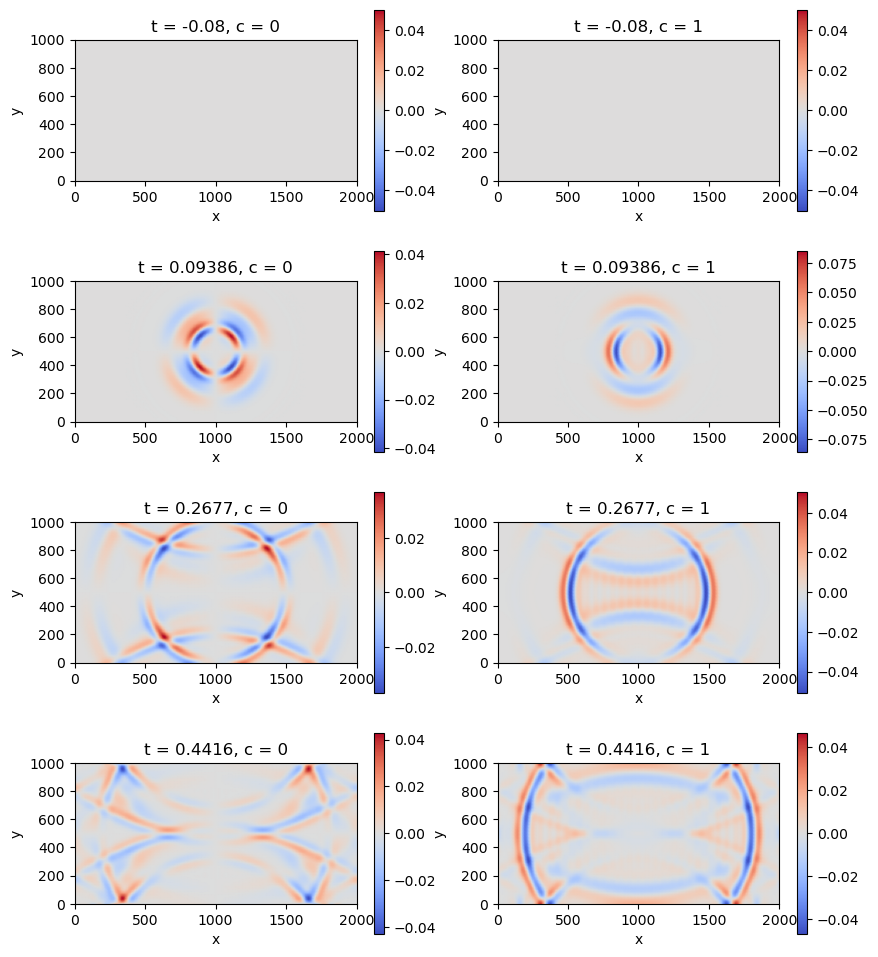

In [231]:
number_of_plots = 4

subsamp = wavefields_as_xarray.t.size // number_of_plots

selected_times = wavefields_as_xarray.t[::subsamp]

figure, axes = plt.subplots(
    selected_times.size, 2, figsize=(10, 3 * number_of_plots)
)

for it, time in enumerate(selected_times):

    # Select the wavefield at `time`, component x
    ax = wavefields_as_xarray.sel(c=0, t=time).plot(
        shading="gouraud",
        infer_intervals=False,
        cmap="coolwarm",
        ax=axes[it, 0],
    )
    ax.axes.set_aspect("equal")
    # Select the wavefield at `time`, component x
    ax = wavefields_as_xarray.sel(c=1, t=time).plot(
        shading="gouraud",
        infer_intervals=False,
        cmap="coolwarm",
        ax=axes[it, 1],
    )
    ax.axes.set_aspect("equal")